In [547]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from IPython.display import HTML
import scipy.stats as stats 

from scipy.optimize import curve_fit

In [548]:
def poly_fit(x, p0, p1):
    return p0 + p1*x

def uncertainty(array):
    sigma = np.std(array)
    uncer = sigma/np.sqrt(len(array))
    return uncer

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

def addlabels_rank(x,y, rank):
    for i in range(len(x)):
        plt.text(i, y[i]//2 + y[i]//4, "Global\nRank\n" + str(rank[i]), ha = 'center', fontsize=13, color="yellow")

# I) Load Data

In [549]:
raw_data = pd.read_csv("healthcare_prices.csv")

data = raw_data.copy() # remove duplicate index
data.head()

,Countries,"Healthcare prices, 2017",Global rank,Available data
0,Switzerland,241.55,1,2017 - 2017
1,Bermuda,228.75,2,2017 - 2017
2,Iceland,228.54,3,2017 - 2017
3,Norway,198.81,4,2017 - 2017
4,Sweden,189.48,5,2017 - 2017


# II) Check Value NAN

In [550]:
header_name = ["Countries", "Healthcare prices, 2017", "Global rank", "Available data"]

for i in range(len(header_name)):
    print("Total data NAN in", header_name[i], ":", data[header_name[i]].isna().sum())

Total data NAN in Countries : 0
Total data NAN in Healthcare prices, 2017 : 0
Total data NAN in Global rank : 0
Total data NAN in Available data : 0


In [551]:
data.describe()

,"Healthcare prices, 2017",Global rank
count,167.000000,167.00000
mean,70.354790,84.00000
std,46.445983,48.35287
min,14.370000,1.00000
25%,37.790000,42.50000
50%,52.800000,84.00000
75%,90.940000,125.50000
max,241.550000,167.00000


# III) Fitting Data

In [552]:
x = data["Global rank"] 
y = data["Healthcare prices, 2017"]
lny = np.log(y)

In [553]:
popt, pcov = curve_fit(poly_fit, x, lny)
yhat = poly_fit(x, popt[0], popt[1])
yhat_exp = np.exp(yhat)
uncer = uncertainty(y)

Text(0.5, 0, 'Global rank')

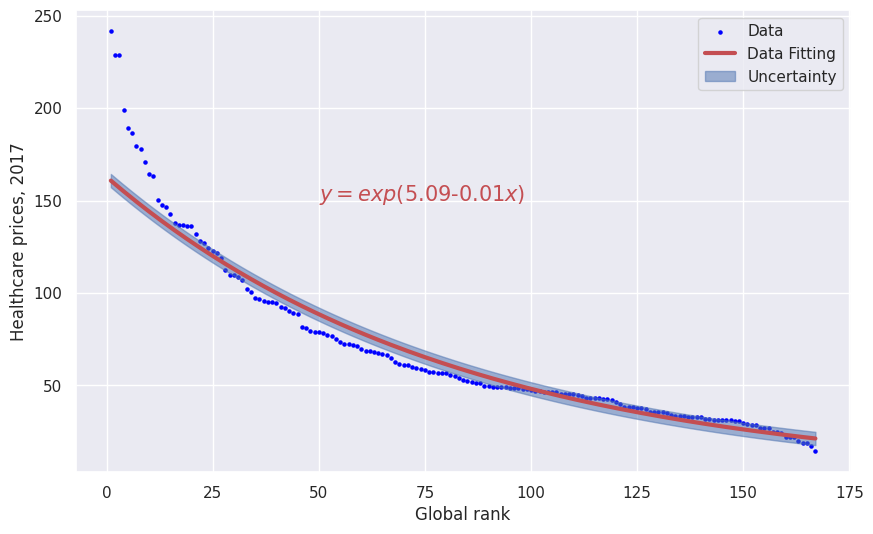

In [554]:
plt.figure(figsize=(10, 6))

plt.scatter(x, y, color="blue", s=5, label="Data")
plt.plot(x, yhat_exp, c='r', linewidth=3, label="Data Fitting")
plt.fill_between(x, yhat_exp-uncer, yhat_exp+uncer, color="b", alpha=0.5, label="Uncertainty")

plt.text(50, 150, r"$y=exp($" + str(np.round(popt[0], 2)) + str(np.round(popt[1], 2)) + r"$x)$", fontsize=15, color='r')

plt.legend()
plt.ylabel("Healthcare prices, 2017")
plt.xlabel("Global rank")

In [555]:
chi_square_test_statistic, p_value = stats.chisquare( lny, yhat)
chi_square_limit = stats.chi2.ppf(1-0.05, df=(len(lny) - 2))

parameter = pd.DataFrame({
    "Para": ["a", "b"],
    "Value": [popt[0], popt[1]],
    "Uncer": [pcov[0][0], pcov[1][1]] 
})

print("Std is:", uncer)
print('chi_square_test_statistic is: ' + str(chi_square_test_statistic))
print("chi_square_limit is: " + str(chi_square_limit))
print('p_value: ' + str(p_value))

HTML(parameter.to_html(index=False))

Std is: 3.5833211355712953
chi_square_test_statistic is: 0.49825235942980944
chi_square_limit is: 195.9733619739493
p_value: 1.0


Para,Value,Uncer
a,5.092065,2.993363e-04
b,-0.012182,3.191219e-08


# IV) New Table with Fitting Data

In [556]:
data_fitting = pd.DataFrame({
    "Countries": data["Countries"],
    "Healthcare prices": yhat_exp,
    "Global rank": data["Global rank"]
})

data_fitting.describe()

,Healthcare prices,Global rank
count,167.000000,167.00000
mean,69.104026,84.00000
std,39.406236,48.35287
min,21.276645,1.00000
25%,35.275781,42.50000
50%,58.483589,84.00000
75%,96.963325,125.50000
max,160.755143,167.00000


### Fitting a linear equation so when the ranking decreases, the price increases

## Top 20 Countries Global Ranking

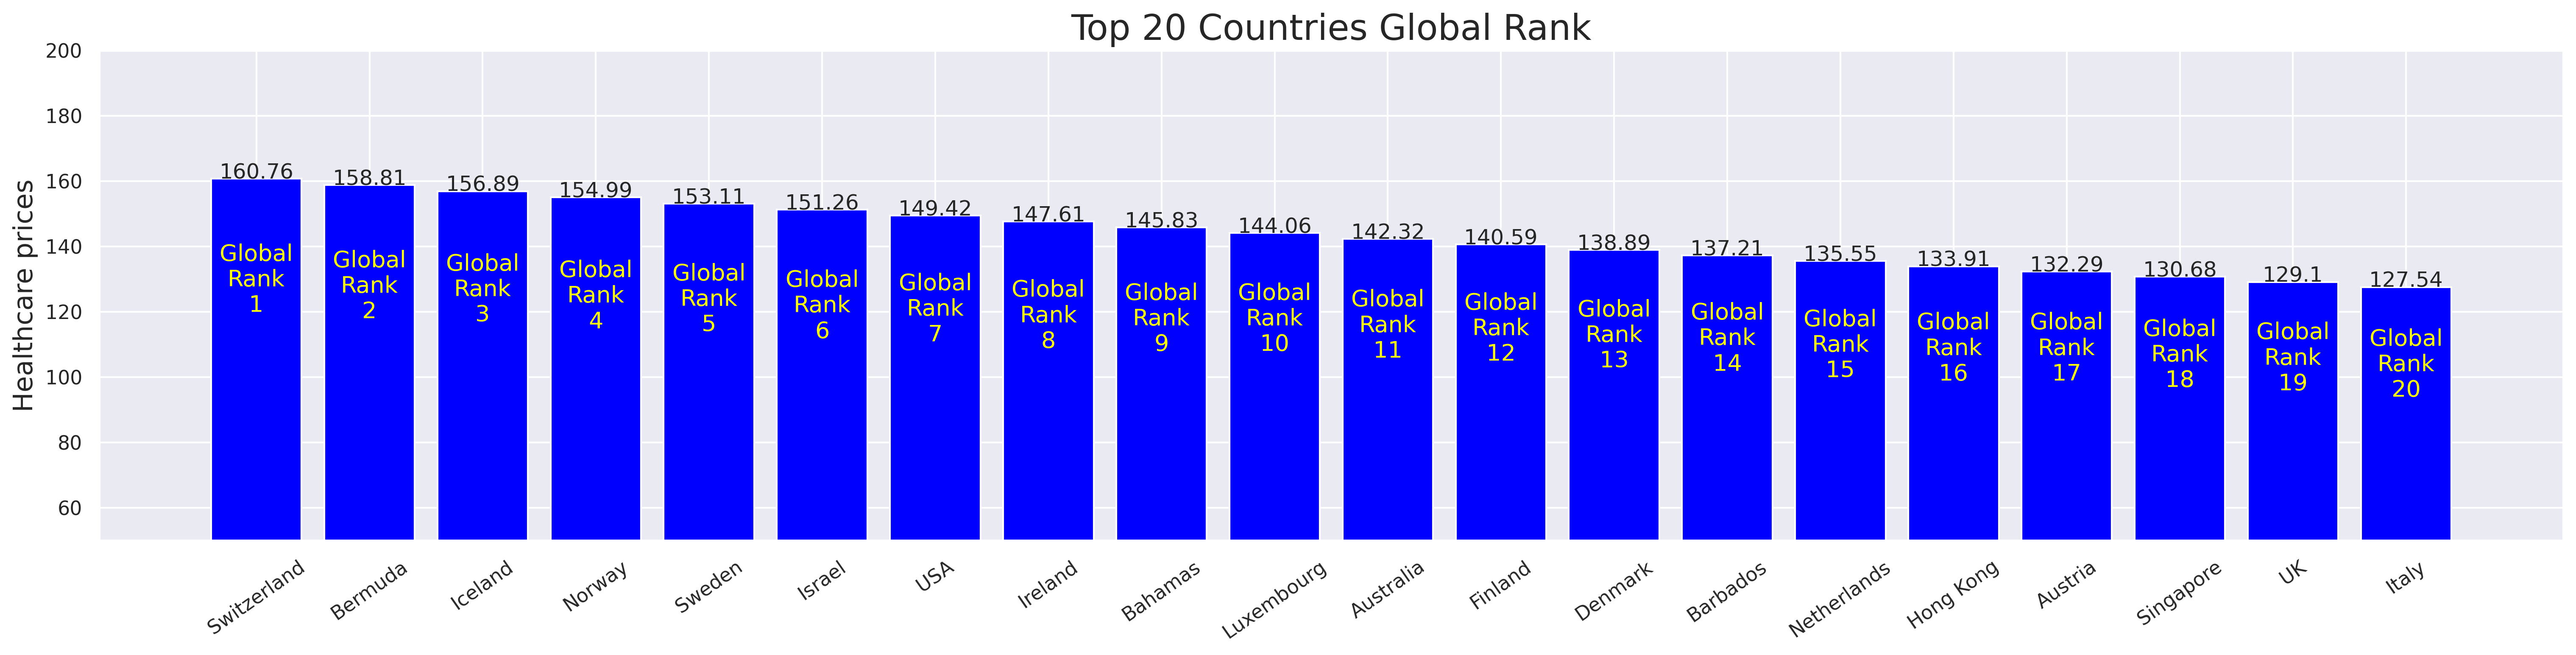

In [557]:
top_20_rank = data_fitting[0:20].copy().sort_values(by="Global rank")

plt.figure(figsize=(25, 5), dpi=300)

plt.bar(top_20_rank['Countries'], top_20_rank["Healthcare prices"], color='blue')
addlabels(top_20_rank['Countries'], np.round(top_20_rank["Healthcare prices"],2))
addlabels_rank(top_20_rank['Countries'],top_20_rank["Healthcare prices"], top_20_rank["Global rank"])

plt.title("Top 20 Countries Global Rank", fontsize=20)
plt.ylabel("Healthcare prices", fontsize=15)
plt.xticks(rotation=35)
plt.ylim(50, 200)
plt.show()

### Top Countries with Median Healthcare Prices

#### Median Healthcare prices $\pm$ Uncertainty

In [558]:
countries = []
prices = []
ranks = []
median = np.mean(data_fitting["Healthcare prices"])
for i in range(len(data_fitting)):
    if data_fitting["Healthcare prices"][i] >= median - uncer and data_fitting["Healthcare prices"][i] <= median + uncer:
        countries.append(data_fitting["Countries"][i])
        prices.append(data_fitting["Healthcare prices"][i])
        ranks.append(data_fitting["Global rank"][i])

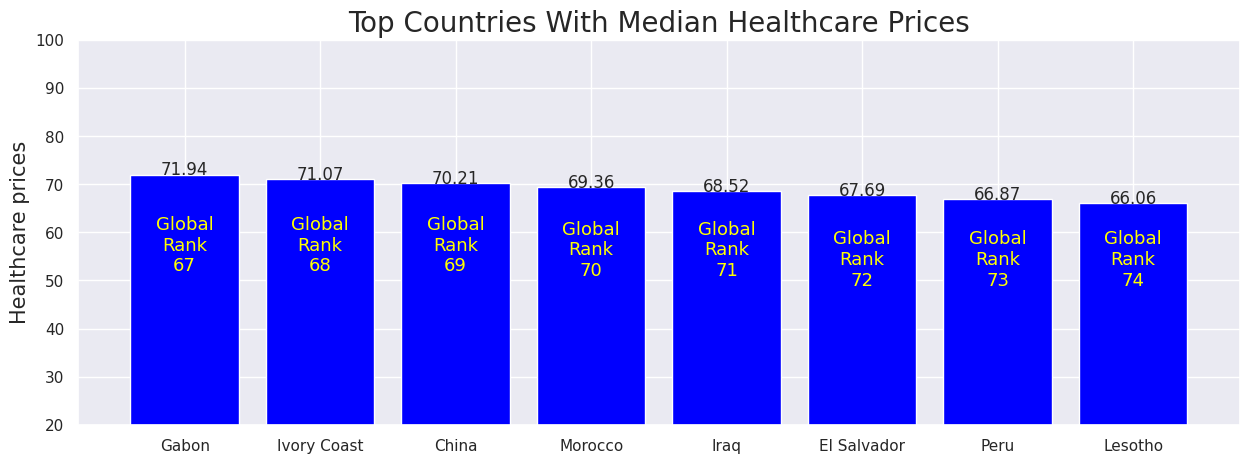

In [559]:
plt.figure(figsize=(15, 5))

plt.bar(countries, prices, color='blue')
addlabels(countries, np.round(prices,2))
addlabels_rank(countries, prices, ranks)

plt.title("Top Countries With Median Healthcare Prices", fontsize=20)
plt.ylabel("Healthcare prices", fontsize=15)
plt.ylim(20, 100)
plt.show()

## Top 20 Countries with BAD Global Ranking

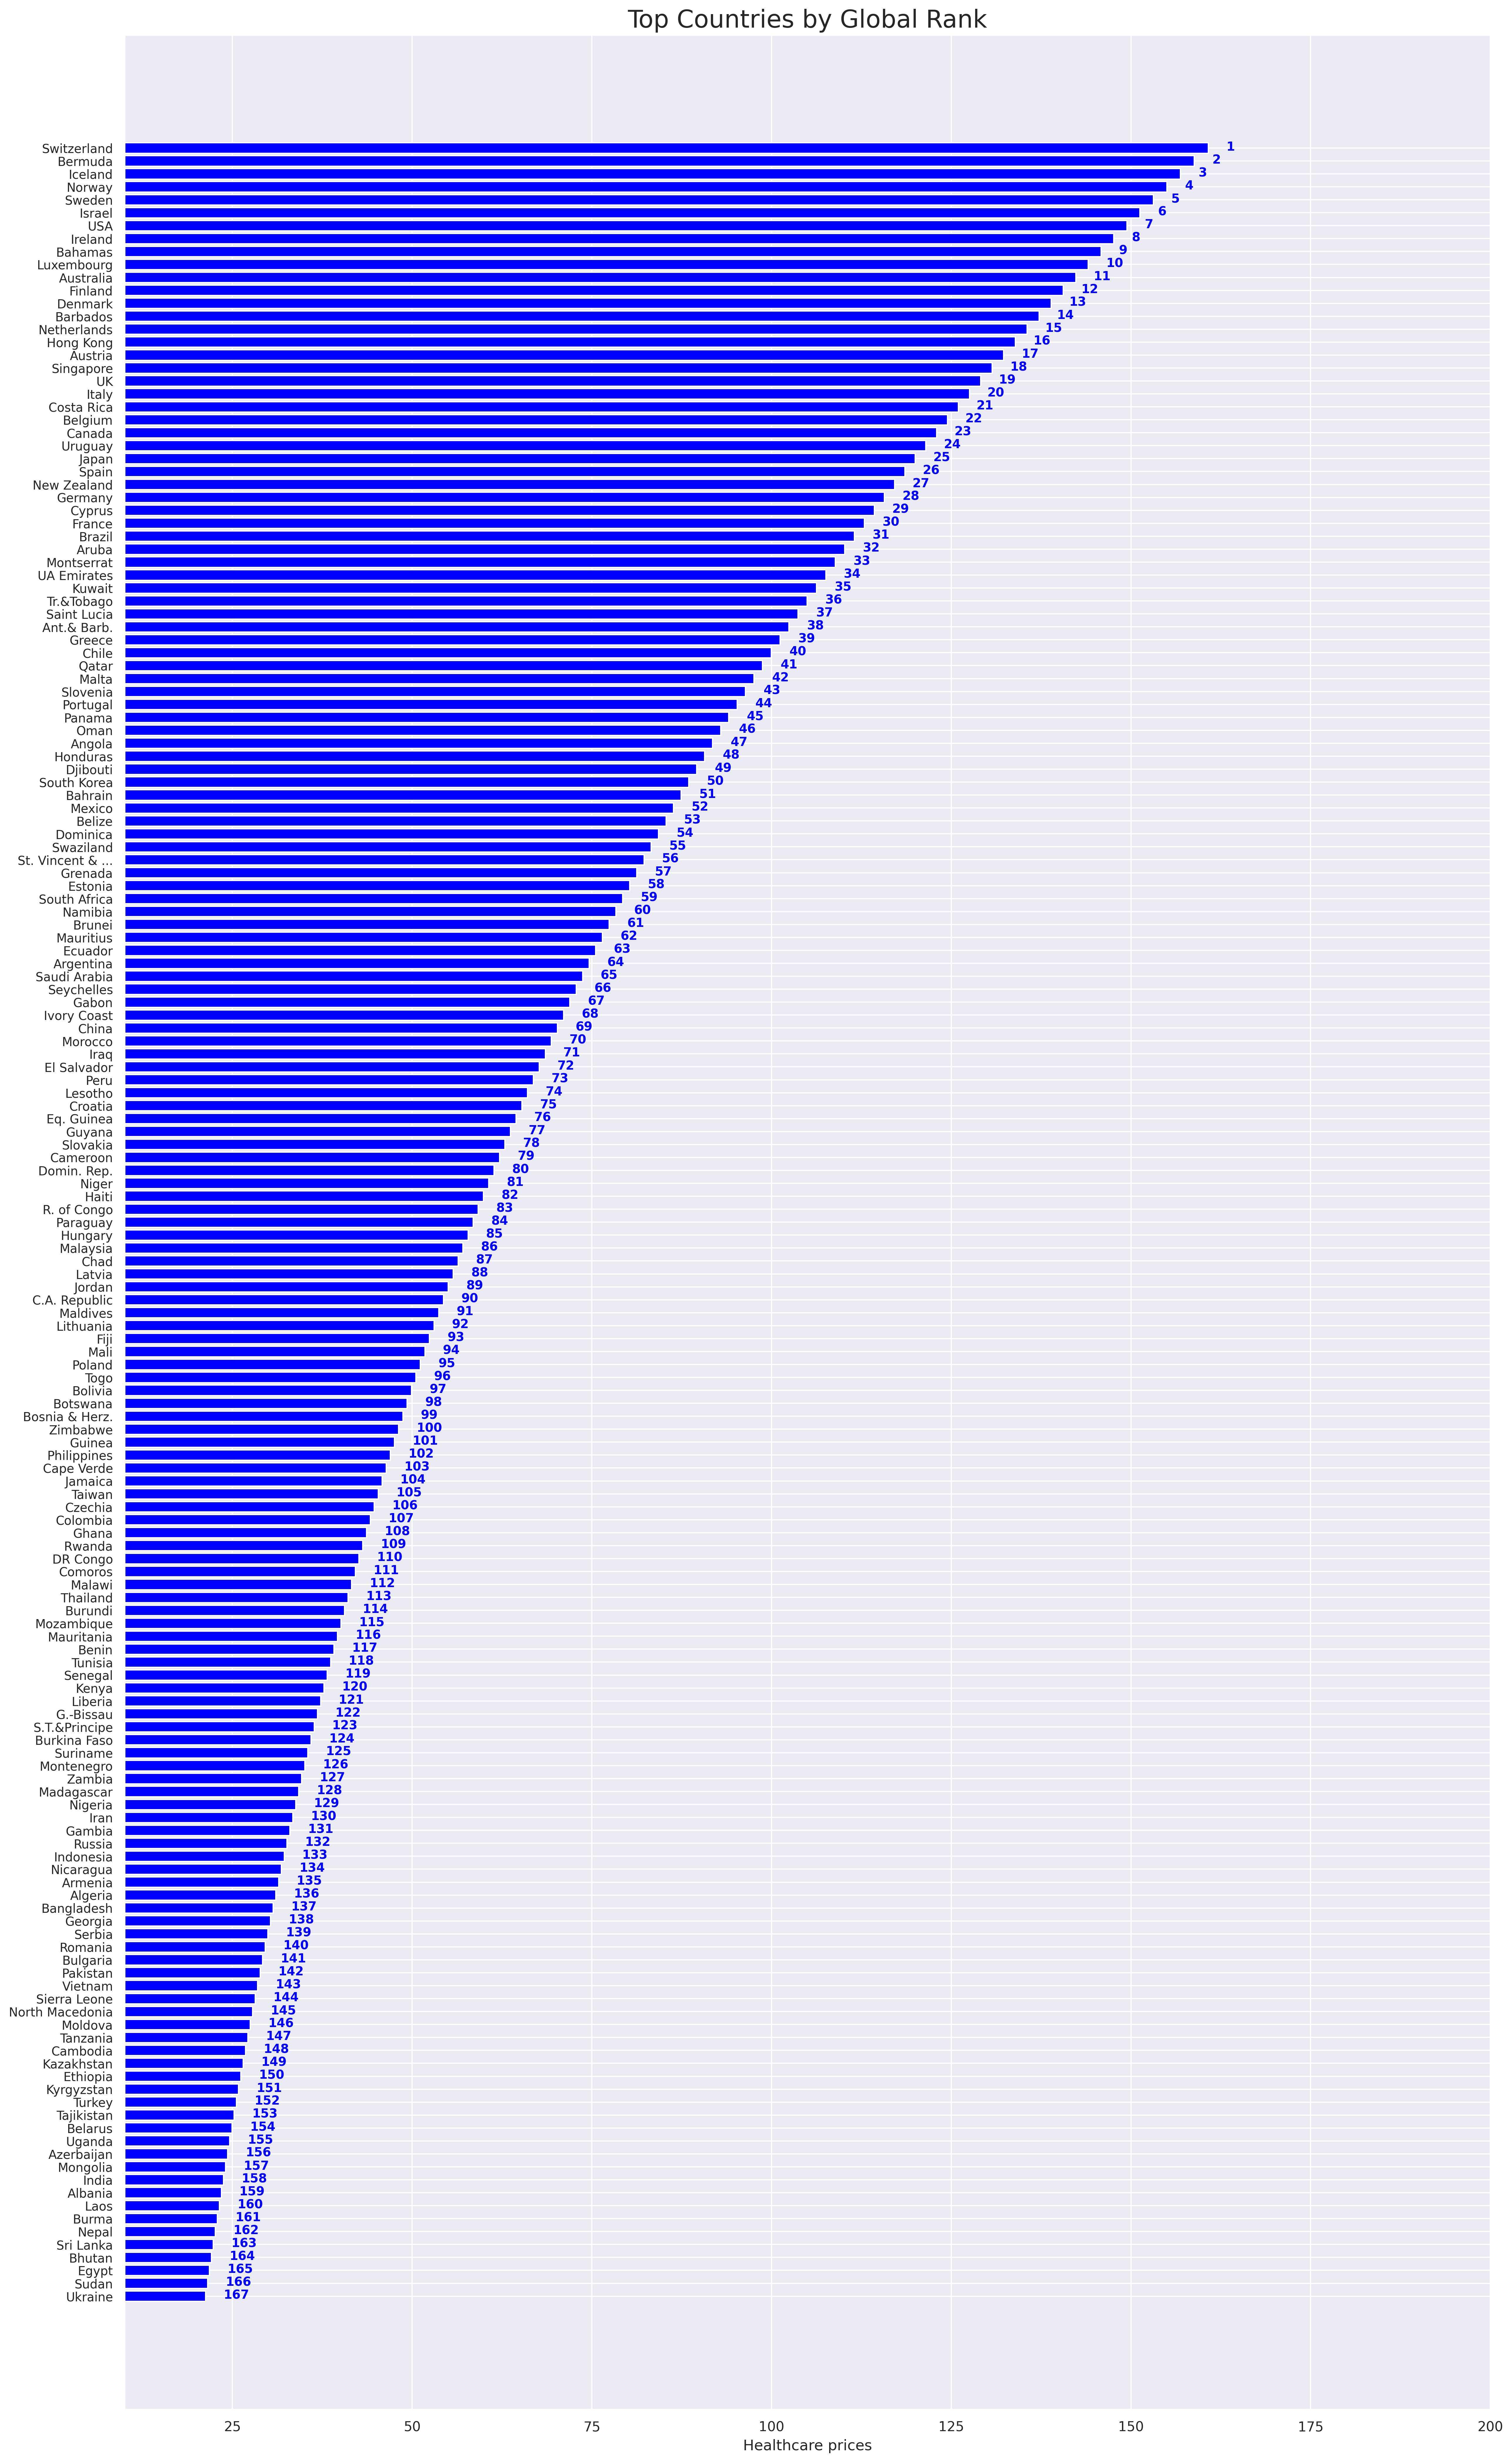

In [560]:
top_rank = data_fitting.copy().sort_values(by="Global rank", ascending=False)
plt.figure(figsize=(20, 35), dpi=300)

plt.barh(top_rank['Countries'], top_rank["Healthcare prices"], color='blue')
plt.xlabel("Healthcare prices")

plt.yticks(fontsize=10)
plt.title("Top Countries by Global Rank", fontsize=20)

for i, v in enumerate(top_rank["Healthcare prices"]):
    plt.text(v + 2.5, i-0.2, str( top_rank["Global rank"][len(top_rank) - 1 - i]), color='blue', fontweight='bold', fontsize=10)

plt.xlim(10, 200)

plt.show()
